<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/week7%E4%BD%9C%E6%A5%AD_%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##作業1：使用 TensorFlow 或 PyTorch 實作類神經網路模型預測股票價格（TensorFlow 使用 Dense layer；PyTorch 使用 Linear layer）。(說明：使用收盤價或技術指標預測，預測N日後的股價。)

In [ ]:
!pip install yfinance pandas numpy torch scikit-learn matplotlib

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim

In [ ]:
tsmc = yf.download('2330.TW', start='2020-01-01')
tsmc

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW
Date,,,,,,
2020-01-02 00:00:00+00:00,306.430206,339.0,339.0,332.5,332.5,31754120
2020-01-03 00:00:00+00:00,306.882141,339.5,345.0,335.5,344.0,41811268
2020-01-06 00:00:00+00:00,300.102783,332.0,334.5,332.0,333.0,45343057
2020-01-07 00:00:00+00:00,297.842865,329.5,333.0,326.5,332.5,50879181
2020-01-08 00:00:00+00:00,297.842865,329.5,333.0,325.0,325.0,37567748
...,...,...,...,...,...,...
2024-10-23 00:00:00+00:00,1060.000000,1060.0,1070.0,1055.0,1060.0,31423466
2024-10-24 00:00:00+00:00,1060.000000,1060.0,1075.0,1055.0,1070.0,38236996


In [ ]:
def create_features(df):
    df_feat = df.copy()
    df_feat['Returns'] = df_feat['Close'].pct_change()
    df_feat['MA5'] = df_feat['Close'].rolling(window=5).mean()
    df_feat['MA20'] = df_feat['Close'].rolling(window=20).mean()
    df_feat['MA5-MA20'] = df_feat['MA5'] - df_feat['MA20']
    df_feat['RSI'] = calculate_rsi(df_feat['Close'])
    df_feat = df_feat.dropna()
    return df_feat

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_features = create_features(tsmc)
feature_columns = ['Returns', 'MA5', 'MA20', 'MA5-MA20', 'RSI',
           'Open', 'High', 'Low', 'Close']
X = df_features[feature_columns].values
y = df_features['Close'].shift(-1).values[:-1]
X = X[:-1]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(X_scaled) * 0.8)

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class StockANN(nn.Module):
    def __init__(self, input_size):
        super(StockANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)


model = StockANN(len(feature_columns))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)  # 計算損失
        loss.backward()  # 反向傳播
        optimizer.step()  # 更新權重
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')


Epoch 10/100, Loss: 0.0005
Epoch 20/100, Loss: 0.0004
Epoch 30/100, Loss: 0.0003
Epoch 40/100, Loss: 0.0003
Epoch 50/100, Loss: 0.0003
Epoch 60/100, Loss: 0.0003
Epoch 70/100, Loss: 0.0002
Epoch 80/100, Loss: 0.0002
Epoch 90/100, Loss: 0.0002
Epoch 100/100, Loss: 0.0002


In [ ]:
model.eval()
predictions = []
with torch.no_grad():  # 不需要梯度計算
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.numpy())


predictions = scaler_y.inverse_transform(np.concatenate(predictions))
y_test_original = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1))


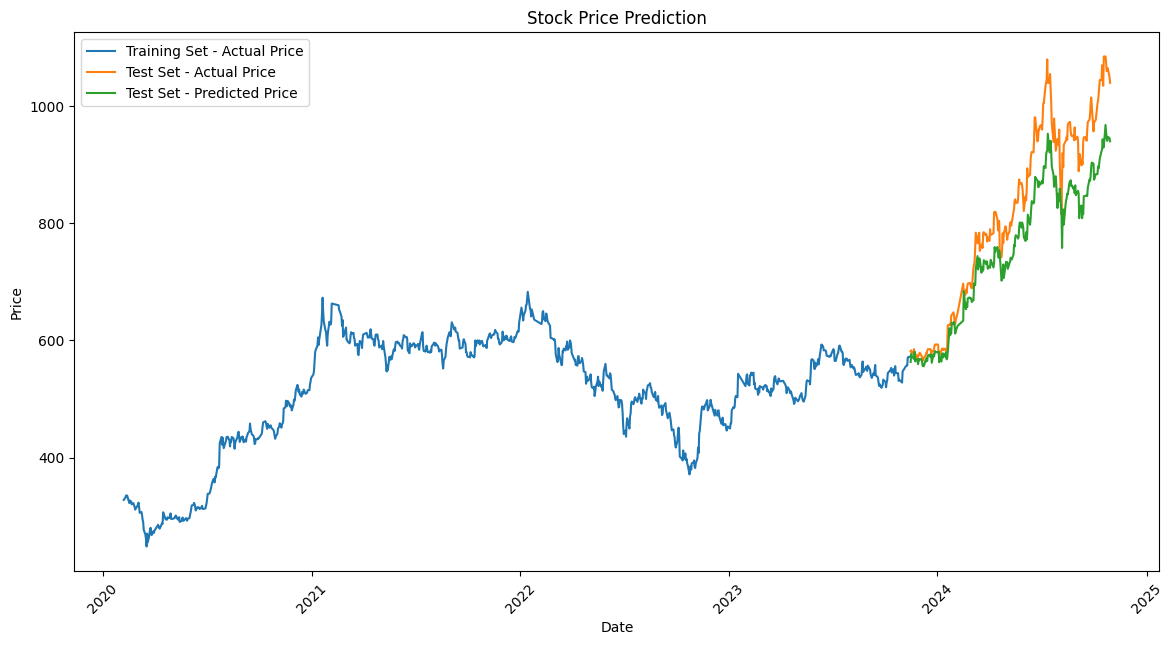

In [ ]:
train_dates = df_features.index[:train_size]
test_dates = df_features.index[train_size + 1:]


train_prices_original = scaler_y.inverse_transform(y_train.numpy().reshape(-1, 1))
test_prices_original = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1))


plt.figure(figsize=(14, 7))
plt.plot(train_dates, train_prices_original, label="Training Set - Actual Price")
plt.plot(test_dates, test_prices_original, label="Test Set - Actual Price")
plt.plot(test_dates, predictions, label="Test Set - Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.xticks(rotation=45)
plt.show()
